In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import  preprocessing, ensemble
from sklearn.metrics import log_loss,accuracy_score
from sklearn.cross_validation import KFold,StratifiedKFold
import re
import string
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

/opt/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#try xgboost
#original fucntion from SRK
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, \
     seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1,\
     max_depth = 6,cv_dict = None,verbose_eval=True):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = eta
    param['max_depth'] = max_depth
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y,feature_names=feature_names)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y,feature_names=feature_names)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,\
        early_stopping_rounds=early_stop,evals_result = cv_dict,verbose_eval = verbose_eval)
    else:
        xgtest = xgb.DMatrix(test_X,feature_names=feature_names)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

class CVstatistics(object):
    
    """
    self.result : the result dataframe storing the cv results
    self.endpoint : the first ending point for the validations
    self.turns: the turns for each validation
    
    validCurve : plot the validation curve,stop at the first endpoint
    errorsAt: return the average errors at a certain turn
    """
    def __init__(self,result_dict,metric,k=5):
        self.metric = metric
        if type(result_dict) == pd.DataFrame:
            self.result = result_dict
        else:
            temp_dict = {}
            for phase in ['train','test']:
                for turn in range(k):
                    temp_dict[phase+str(turn)]=cv_result[turn][phase][metric]
                    self.result=pd.DataFrame(dict([ (key,pd.Series(v)) for key,v in temp_dict.iteritems()]))    
        
        self.endpoint =len(self.result.filter(like = 'train').dropna())
        
        self.turns = self.result.filter(like = 'test').\
            apply(lambda x : ~np.isnan(x)).cumsum(axis=0).iloc[len(self.result)-1,:]

    def validCurve(self,start = 0, stop_at_first = True):
        if stop_at_first:
            eout = self.result.iloc[start:,:].filter(like = 'test').dropna().mean(axis=1)
            ein =  self.result.iloc[start:,:].filter(like = 'train').dropna().mean(axis=1)
        else:
            eout = self.result.iloc[start:,:].filter(like = 'test').mean(axis=1)
            ein =  self.result.iloc[start:,:].filter(like = 'train').mean(axis=1)
        plt.plot(map(lambda x :x+start,range(len(eout))), eout,
        map(lambda x :x+start,range(len(ein))), ein)
        plt.xlabel("turn")
        plt.ylabel(self.metric)
        plt.title('Validation Curve')
        
        plt.show()
    
    def errorsAt(self,turn):
        eout = self.result.filter(like = 'test').loc[turn].mean()
        ein = self.result.filter(like = 'train').loc[turn].mean()
        return eout,ein
    
def xgbImportance(model,factor_name):
    factors = model.get_score(importance_type=factor_name)
    factor_list = []
    total = sum(factors.values())
    for key in factors:
        factors[key] = factors[key]*1.0/total
        factor_list.append((key,factors[key]))
    return sorted(factor_list,key=lambda x : x[1],reverse=True)
    


In [4]:
#feature processing functions
#define punctutaion filter
def removePunctuation(x):
    #filter the head or tail blanks
    x = re.sub(r'^\s+',r' ',x)
    x = re.sub(r'\s+$',r' ',x)
    
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars, warning if you are dealing with other languages!!!!!!!!!!!!!!!
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    #change all the blank to space
    x = re.sub(r'\s',r' ',x)
    # Removing (replacing with empty spaces actually) all the punctuations
    removing = string.punctuation#.replace('-','')# except '-'
    removed = re.sub("["+removing+"]", "", x)
    #removing the line-changing
    #removed = re.sub('\\n'," ",removed)    
    return removed

#feature processing functions
def proecessStreet(address):
    #remove the building number
    pattern = re.compile('^[\d-]*[\s]+')
    street = removePunctuation(pattern.sub('',address))
    
    #sub the st to street
    pattern = re.compile('( st)$')
    street = pattern.sub(' street',street)
    
    #sub the ave to avenue
    pattern = re.compile('( ave)$')
    street = pattern.sub(' avenue',street)
    
    pattern = re.compile('(\d+)((th)|(st)|(rd)|(nd))')
    street = pattern.sub('\g<1>',street)
    
    #deal with the w 14 street => west 14 street
    pattern = re.compile('(w)(\s+)(\d+)')    
    street = pattern.sub('west \g<3>',street)
    
    #deal with the e....
    pattern = re.compile('(e)(\s+)(\d+)')    
    street = pattern.sub('east \g<3>',street)
    
    return street
    
#from "this is a lit"s python version by rakhlin
def singleValueConvert(df1,df2,column,minimum_size=5):
    ps = df1[column].append(df2[column])
    grouped = ps.groupby(ps).size().to_frame().rename(columns={0: "size"})
    df1.loc[df1.join(grouped, on=column, how="left")["size"] <= minimum_size, column] = -1
    df2.loc[df2.join(grouped, on=column, how="left")["size"] <= minimum_size, column] = -1
    return df1, df2



In [5]:
def performance_eval(train_df,test_df,feature,k,g=1,f=1,update_df =None,random = None):
    target_num_map = {'High':2, 'Medium':1, 'Low':0}
    temp=pd.concat([train_df[feature],pd.get_dummies(train_df.interest_level)], axis = 1)\
         .groupby(feature).mean()
     
    new_feature = feature+'_perf'
    
    temp.columns = ['tempHigh','tempLow', 'tempMed']
    
    temp['count'] = train_df.groupby(feature).count().iloc[:,1]
    temp["lambda"] = g / (g + np.exp((k - temp["count"] )/f))
    temp[feature+'_origin'] = temp['tempHigh']*2 + temp['tempMed']
    mean_values = temp.loc[:, feature+'_origin'].mean()
    
    temp[new_feature] = temp["lambda"]*temp[feature+'_origin']+(1-temp["lambda"])*mean_values    
    
    # Add uniform noise. Not mentioned in original paper.adding to each manager
    if random:
        temp[new_feature] *= np.random.uniform(1 - random, 1 + random, len(temp))     

    value = test_df[[feature]].join(temp, on=feature, how="left")[new_feature].fillna(mean_values)
    
    if update_df is None: update_df = test_df
    if new_feature not in update_df.columns: update_df[new_feature] = np.nan
    update_df.update(value)

In [6]:
#functions for features
def featureList(train_df,test_df,limit = 0.001):
    #acquiring the feature lists
    features_in_train = train_df["features"].apply(pd.Series).unstack().reset_index(drop = True).dropna().value_counts()
    features_in_test = test_df["features"].apply(pd.Series).unstack().reset_index(drop = True).dropna().value_counts()
    
    filtered_features_in_train = features_in_train[features_in_train > limit*len(train_df)]
    filtered_features_in_test = features_in_test[features_in_test > limit*len(test_df)]
    accept_list = set(filtered_features_in_train.index).union(set(filtered_features_in_test.index))
    return accept_list

def featureMapping(train_df,test_df,feature_list):
    for feature in feature_list:
        #add the feature column for both
        #if feature in the row, then set the value for (row,feature) to 1
        train_df['with_'+feature]=train_df['features'].apply(lambda x : 1 if feature in x else 0)
        test_df['with_'+feature]=test_df['features'].apply(lambda x : 1 if feature in x else 0)
    return


In [7]:
#lodaing data
data_path = "../../kaggleData/2sigma/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)


(49352, 15)
(74659, 14)


In [8]:
#basic numerical features
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

In [9]:
#some transfromed features
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

#some new numerical features related to the price
train_df["price_per_bath"] =  (train_df["price"]*1.0/train_df["bathrooms"]).replace(np.Inf,-1)
train_df["price_per_bed"] = (train_df["price"]*1.0/train_df["bedrooms"]).replace(np.Inf,-1)
train_df["bath_per_bed"] = (train_df["bathrooms"]*1.0/train_df["bedrooms"]).replace(np.Inf,-1)
train_df["price_per_room"] = (train_df["price"]*1.0/(train_df["bedrooms"]+train_df["bathrooms"])).replace(np.Inf,-1)

test_df["price_per_bath"] =  (test_df["price"]*1.0/test_df["bathrooms"]).replace(np.Inf,-1)
test_df["price_per_bed"] = (test_df["price"]*1.0/test_df["bedrooms"]).replace(np.Inf,-1)
test_df["bath_per_bed"] = (test_df["bathrooms"]*1.0/test_df["bedrooms"]).replace(np.Inf,-1)
test_df["price_per_room"] = (test_df["price"]*1.0/(test_df["bedrooms"]+test_df["bathrooms"])).replace(np.Inf,-1)


# adding all these new features to use list # "listing_id",
features_to_use.extend(["num_photos", "num_features", "num_description_words",\
                        "created_year","listing_id", "created_month", "created_day", "created_hour"])
#price new features
features_to_use.extend(["price_per_bed","bath_per_bed","price_per_room"])


In [10]:
"""
new categorical data generated from the old ones
"""
#new feature for the street_address, use them instead of the original one
train_df["street_name"] = train_df["street_address"].apply(proecessStreet)
test_df["street_name"] = test_df["street_address"].apply(proecessStreet)


In [11]:
#dealing with features

#preprocessing for features
train_df["features"] = train_df["features"].apply(lambda x:["_".join(i.split(" ")).lower().strip().replace('-','_') \
                                                            for i in x])
test_df["features"] = test_df["features"].apply(lambda x:["_".join(i.split(" ")).lower().strip().replace('-','_')\
                                                          for i in x])
#create the accept list
accept_list = list(featureList(train_df,test_df,limit = 0.001))

#map the feature to dummy slots
featureMapping(train_df,test_df,accept_list)
features_to_use.extend(map(lambda x : 'with_'+x,accept_list))

In [12]:
#shorten reprocessing time: save the preprocessed train_df and test_df with some basic features
train_df.to_json('train1.3std.json')
test_df.to_json('test1.3std.json')
print features_to_use

['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_description_words', 'created_year', 'listing_id', 'created_month', 'created_day', 'created_hour', 'price_per_bed', 'bath_per_bed', 'price_per_room', u'with_exclusive', u'with_furnished', u'with_lowrise', u'with_common_parking/garage', u'with_pets_on_approval', u'with_terrace', u'with_live_in_superintendent', u'with_newly_renovated', u'with_full_time_doorman', u'with_duplex', u'with_dryer_in_unit', u'with_multi_level', u'with_garden', u'with_hardwood_floors', u'with_on_site_garage', u'with_fireplace', u'with_eat_in_kitchen', u'with_wifi_access', u'with_garage', u'with_subway', u'with_dining_room', u'with_view', u'with_publicoutdoor', u'with_hardwood', u'with_fitness_center', u'with_high_speed_internet', u'with_laundry_in_building', u'with_parking', u'with_garden/patio', u'with_prewar', u'with_on_site_laundry', u'with_valet', u'with_green_building', u'with_short_term_allowed', u'with_new_constr

In [ ]:
#shorten reprocessing time: load the preprocessed train_df and test_df with some basic features
t_train_df=pd.read_json('train1.3std.json')
test_df=pd.read_json('test1.3std.json')
features_to_use = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_description_words', 'created_year', 'listing_id', 'created_month', 'created_day', 'created_hour', 'price_per_bed', 'bath_per_bed', 'price_per_room', u'with_exclusive', u'with_furnished', u'with_lowrise', u'with_common_parking/garage', u'with_pets_on_approval', u'with_terrace', u'with_live_in_superintendent', u'with_newly_renovated', u'with_full_time_doorman', u'with_duplex', u'with_dryer_in_unit', u'with_multi_level', u'with_garden', u'with_hardwood_floors', u'with_on_site_garage', u'with_fireplace', u'with_eat_in_kitchen', u'with_wifi_access', u'with_garage', u'with_subway', u'with_dining_room', u'with_view', u'with_publicoutdoor', u'with_hardwood', u'with_fitness_center', u'with_high_speed_internet', u'with_laundry_in_building', u'with_parking', u'with_garden/patio', u'with_prewar', u'with_on_site_laundry', u'with_valet', u'with_green_building', u'with_short_term_allowed', u'with_new_construction', u'with_reduced_fee', u'with_roofdeck', u'with_stainless_steel_appliances', u'with_simplex', u'with_dishwasher', u'with_washer_in_unit', u'with_cats_allowed', u'with_exposed_brick', u'with_roof_deck', u'with_common_outdoor_space', u'with_outdoor_areas', u'with_common_roof_deck', u'with_no_pets', u'with_childrens_playroom', u'with_central_a/c', u'with_wheelchair_access', u'with_post_war', u'with_renovated', u'with_elevator', u'with_highrise', u'with_loft', u'with_gym', u'with_luxury_building', u'with_outdoor_space', u'with_pre_war', u'with_residents_lounge', u'with_laundry_room', u'with_marble_bath', u'with_laundry_in_unit', u'with_parking_space', u'with_private_outdoor_space', u'with_high_ceiling', u'with_concierge', u'with_walk_in_closet(s)', u'with_doorman', u'with_balcony', u'with_dogs_allowed', u'with_gym/fitness', u'with_storage', u'with_live_in_super', u'with_lounge', u'with_granite_kitchen', u'with_private_balcony', u'with_laundry', u'with_actual_apt._photos', u'with_residents_garden', u'with_pool', u'with_washer/dryer', u'with_light', u'with_swimming_pool', u'with_high_ceilings', u'with_patio', u'with_no_fee', u'with_bike_room']

In [12]:
#prepare for validation
target_num_map = {'high':0, 'medium':1, 'low':2}

train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

KF=StratifiedKFold(train_y,5,shuffle=True,random_state = 42)

train_df = train_df.fillna(-1)
test_df = test_df.fillna(-1)

In [13]:
#the basic features from preprocessing 
features = list(features_to_use)

#features to be added during cv by cv-manner statistics
features.extend(['manager_id_perf'])
#categorical features to be added
categorical = ["display_address", "street_address","street_name",'building_id','manager_id']
features.extend(categorical)

In [ ]:
#running and getting the cv from xgboost
cv_scores = []
cv_result = []

for dev_index, val_index in KF: 
    result_dict = {}
    
    dev_set, val_set = train_df.iloc[dev_index,:] , train_df.iloc[val_index,:] 
    
    #=============================================================        
    """feature engineerings for the categorical features"""
    #fill substitute the small size values by their mean
    for f in ['display_address','manager_id','building_id','street_name']:
        dev_set,val_set  = singleValueConvert(dev_set,val_set,f,1)
    
    
    #K-FOLD evaluation for the statistic features
    
    skf=StratifiedKFold(dev_set['interest_level'],5,shuffle=True,random_state = 42)
    #dev set adding manager skill
    for feature in ['manager_id']:
        for train,test in skf:
            performance_eval(dev_set.iloc[train,:],dev_set.iloc[test,:],feature=feature,k=5,g=10,
                           update_df = dev_set)
        
        performance_eval(dev_set,val_set,feature=feature,k=5,g=10)
    
    
    for f in categorical:
    
        if dev_set[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(dev_set[f])+list(val_set[f]))
            dev_set[f] = lbl.transform(list(dev_set[f].values))
            val_set[f] = lbl.transform(list(val_set[f].values))
    
    #============================================================
            
    #filter the features
    dev_X, val_X = dev_set[features].as_matrix(), val_set[features].as_matrix()
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    """
    runXGB(dev_X, train_y, val_X, test_y=None, feature_names=None, \
    seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1, max_depth = 6)
    """        
    
    #preds,model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=features,\
    #       early_stop = 64,eta = 0.1,max_depth=4,cv_dict = result_dict,verbose_eval=False)

    #for finding the best round
    preds,model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=features,\
           num_rounds = 770,eta = 0.1,max_depth=4,cv_dict = result_dict,verbose_eval=100,early_stop=None)
    
    loss = log_loss(val_y, preds)
    cv_scores.append(loss)
    cv_result.append(result_dict)


/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

[0]	train-mlogloss:1.03782	test-mlogloss:1.03805
[100]	train-mlogloss:0.536409	test-mlogloss:0.559347
[200]	train-mlogloss:0.499522	test-mlogloss:0.542023


In [18]:
#plot the validation curv
cvResult = CVstatistics(cv_result,'mlogloss')
cvResult.turns

test0    700
test1    700
test2    700
test3    700
test4    700
Name: 699, dtype: int64

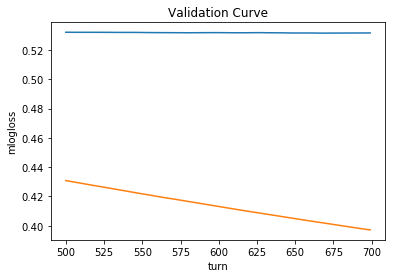

In [19]:
cvResult.validCurve(start =500,stop_at_first = False)


In [63]:
np.mean(cv_scores)

0.53149847310510645

In [55]:
cvResult.errorsAt(550)

(0.5318906, 0.42175019999999996)

In [61]:
#show the importance of the features
xgbImportance(model,'weight')

[('listing_id', 0.07671085177903215),
 ('price', 0.0743324665440477),
 ('manager_id_perf', 0.07262002917485888),
 ('latitude', 0.07090759180567006),
 ('price_per_room', 0.06567514428870426),
 ('longitude', 0.06275765840045665),
 ('street_address', 0.0606329675905372),
 ('manager_id', 0.055939620726834526),
 ('num_description_words', 0.05549565548297076),
 ('building_id', 0.05067546140673559),
 ('price_per_bed', 0.04445994799264286),
 ('street_name', 0.042430392592122786),
 ('display_address', 0.04068624341980085),
 ('created_day', 0.02980909494513858),
 ('num_photos', 0.026701338238092218),
 ('created_hour', 0.025940254962897192),
 ('num_features', 0.023022769074649584),
 ('with_no_fee', 0.008720745861609692),
 ('bedrooms', 0.008498763239677808),
 ('bathrooms', 0.008467051436544682),
 ('bath_per_bed', 0.007071732098687131),
 ('with_furnished', 0.004312805226105157),
 ('with_laundry_in_unit', 0.003773704572842012),
 ('with_hardwood_floors', 0.003678569163442633),
 ('with_laundry_in_buil